In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# untility functions for the RNN
from utilis import ALL_LETTERS, N_LETTERS, load_data, random_training_example, letter_to_tensor, line_to_tensor

In [2]:
class RNN(nn.Module):
    # nn.RNN 
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax =  nn.LogSoftmax(dim=1) # dim=1 means along the row
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    
category_lines, all_categories = load_data() # category_lines is a dictionary having key as category and value as list of names & all_categories is a list of all countries
n_categories = len(all_categories) # number of countries
print(n_categories, all_categories)

18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [3]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)# input_size, hidden_size, output_size

# step one
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [4]:
# whole sequence/name
input_tensor = line_to_tensor('Sagar')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [5]:
# some helper functions
def category_from_output(output):
    # top_n, top_i = output.topk(1)
    # category_i = top_i[0].item()
    category_i = torch.argmax(output).item()
    return all_categories[category_i]#, category_i

# Not trained yet
print(category_from_output(output)) # output is a tensor of size 1 x n_categories

English


In [6]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

5000 5.0 1.4513 Wintersgill / English CORRECT
10000 10.0 0.2181 Szweda / Polish CORRECT
15000 15.0 0.0027 Kotsiopoulos / Greek CORRECT
20000 20.0 0.1283 Gorbovsky / Russian CORRECT
25000 25.0 1.1921 Banh / Korean WRONG (Vietnamese)
30000 30.0 1.1923 Flynn / Irish CORRECT
35000 35.0 0.4345 Fei / Chinese CORRECT
40000 40.0 0.2385 Varela / Spanish CORRECT
45000 45.0 0.9768 Ho / Vietnamese WRONG (Korean)
50000 50.0 0.0768 Reynders / Dutch CORRECT
55000 55.00000000000001 0.7080 Cai / Chinese CORRECT
60000 60.0 1.0893 Janda / Polish CORRECT
65000 65.0 2.6068 Rhee / Irish WRONG (Korean)
70000 70.0 2.2108 Goebel / Czech WRONG (German)
75000 75.0 0.8750 Chun / Korean CORRECT
80000 80.0 2.2363 Quinones / Arabic WRONG (Spanish)
85000 85.0 0.3369 Atiyeh / Arabic CORRECT
90000 90.0 0.2341 Naifeh / Arabic CORRECT
95000 95.0 1.2190 Almeida / Portuguese CORRECT
100000 100.0 0.2482 Do / Vietnamese CORRECT


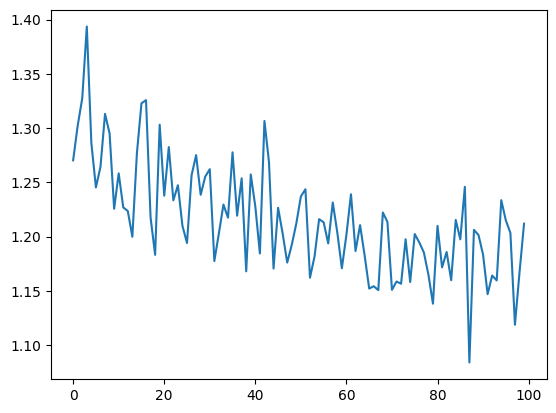

In [8]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = 'CORRECT' if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")
        
plt.figure()
plt.plot(all_losses)
plt.show()

torch.save(rnn.state_dict(), 'rnn.pth')

In [12]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
        
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
            
        guess = category_from_output(output)
        print(guess)
while True:
    sentence = input("Input: ")
    if sentence == 'quit':
        break
    predict(sentence)


> Adam
Irish

> Adam
Irish

> Cen
Korean

> Han
Chinese
